## 1. renamed
## 2. resize_and_crop
## 3. segment person or cloth with sam2-small
## 4. make masked imgs

## run this code with sam2 env

In [9]:
# pip install accelerate
# !pip install diffusers
# !pip install onnxruntime scipy jsonschema

In [9]:
import sys, os
current_dir = os.getcwd()
project_root_dir = os.path.abspath(os.path.join(current_dir, ".."))
catvton_dir = os.path.join(project_root_dir, "CatVTON")

if catvton_dir not in sys.path:
    sys.path.insert(0, catvton_dir)

In [10]:
import os
import shutil

# Define source directories
renamed_person_dir = os.path.join(project_root_dir, "data", "renamed", "renamed_person_images")
renamed_cloth_dir  = os.path.join(project_root_dir, "data", "renamed", "renamed_cloth_images")

# Define destination directories for viton-hd style dataset
dest_person_dir = os.path.join(project_root_dir, "data","dataset", "image")
dest_cloth_upper = os.path.join(project_root_dir, "data","dataset", "cloth", "upper_img_sam2")
dest_cloth_lower = os.path.join(project_root_dir, "data","dataset", "cloth", "lower_img_sam2")
dest_mask_upper = os.path.join(project_root_dir, "data","dataset", "cloth", "upper_mask_sam2")
dest_mask_lower = os.path.join(project_root_dir, "data","dataset", "cloth", "lower_mask_sam2")

os.makedirs(dest_person_dir, exist_ok=True)
os.makedirs(dest_cloth_upper, exist_ok=True)
os.makedirs(dest_cloth_lower, exist_ok=True)
os.makedirs(dest_mask_upper, exist_ok=True)
os.makedirs(dest_mask_lower, exist_ok=True)

# 페어 만들기
person_cloth_pairs = {
    "person_image_path" : "",
    "upper_cloth_path" : "",
    "lower_cloth_path" : ""
}
person_cloth_pairs_list = []
#/Users/coldbrew/Documents/VTON-project/data/renamed/renamed_person_images/Jonghyeon_manA_mana_30.jpg
for person_file_name in sorted(os.listdir(renamed_person_dir)):
    person_cloth_pairs["person_image_path"] = os.path.join(renamed_person_dir, person_file_name)
    person_cloth_pairs["upper_cloth_path"] = os.path.join(renamed_cloth_dir, f"{person_file_name.split('_')[1]}00.jpg").lower()
    person_cloth_pairs["lower_cloth_path"] = os.path.join(renamed_cloth_dir, f"{person_file_name.split('_')[2]}01.jpg").lower()
    person_cloth_pairs_list.append(person_cloth_pairs.copy())
    

person_cloth_pairs_list[:5]

[{'person_image_path': 'c:\\Users\\coldbrew\\VTON-project\\data\\renamed\\renamed_person_images\\Jonghyeon_manA_mana_120.jpg',
  'upper_cloth_path': 'c:\\users\\coldbrew\\vton-project\\data\\renamed\\renamed_cloth_images\\mana00.jpg',
  'lower_cloth_path': 'c:\\users\\coldbrew\\vton-project\\data\\renamed\\renamed_cloth_images\\mana01.jpg'},
 {'person_image_path': 'c:\\Users\\coldbrew\\VTON-project\\data\\renamed\\renamed_person_images\\Jonghyeon_manA_mana_150.jpg',
  'upper_cloth_path': 'c:\\users\\coldbrew\\vton-project\\data\\renamed\\renamed_cloth_images\\mana00.jpg',
  'lower_cloth_path': 'c:\\users\\coldbrew\\vton-project\\data\\renamed\\renamed_cloth_images\\mana01.jpg'},
 {'person_image_path': 'c:\\Users\\coldbrew\\VTON-project\\data\\renamed\\renamed_person_images\\Jonghyeon_manA_mana_30.jpg',
  'upper_cloth_path': 'c:\\users\\coldbrew\\vton-project\\data\\renamed\\renamed_cloth_images\\mana00.jpg',
  'lower_cloth_path': 'c:\\users\\coldbrew\\vton-project\\data\\renamed\\renam

### sam2 정의

In [ ]:
# 여러 마스크에서 의상 마스크 찾는 함수 만들기
# 하나만 찾아야하고 여러개면 오류 발생
def find_cloth_mask(cloth_image, masks):
    img_h, img_w = cloth_image.shape[:2]
    x_min, x_max = int(img_w * 0.4), int(img_w * 0.6)  # 이미지 가로 40~60%
    y_min, y_max = int(img_h * 0.4), int(img_h * 0.5)  # 이미지 세로 40~60%

    # 박스 안에 가장 많이 포함되는 마스크 찾기
    best_mask = None
    max_overlap = 0

    for mask in masks:
        x, y, w, h = mask['bbox']
        
        # 마스크의 좌표 (bbox)
        mask_x_min, mask_x_max = x, x + w
        mask_y_min, mask_y_max = y, y + h
        
        # 중앙 박스와의 겹치는 부분 계산
        overlap_x_min = max(x_min, mask_x_min)
        overlap_x_max = min(x_max, mask_x_max)
        overlap_y_min = max(y_min, mask_y_min)
        overlap_y_max = min(y_max, mask_y_max)
        
        # 겹치는 영역의 크기 계산
        overlap_width = max(0, overlap_x_max - overlap_x_min)
        overlap_height = max(0, overlap_y_max - overlap_y_min)
        overlap_area = overlap_width * overlap_height
        
        # 가장 많이 겹치는 마스크 선택
        if overlap_area > max_overlap:
            best_mask = mask
            max_overlap = overlap_area

    # 마스크가 없으면 종료
    if best_mask is None:
        raise print("⚠️ 중앙 박스 안에 포함되는 마스크(상의/바지)를 찾을 수 없습니다.")
    else:
        return best_mask['segmentation']

In [13]:
import sys, os
project_root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sam_root = os.path.join(project_root_dir,"sam2")
sys.path.insert(0, sam_root)

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

model_cfg = os.path.join(sam_root,"checkpoints\sam2.1_hiera_s.yaml")
sam2_checkpoint = os.path.join(sam_root,"checkpoints\sam2.1_hiera_small.pt")

sam2 = build_sam2(model_cfg, sam2_checkpoint, device="cuda", apply_postprocessing=True)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

## 상의, 하의에 대해 회전 마스킹(sam2) -> 배경 제거된 rgb이미지, binary 마스크 

In [ ]:
from utils import resize_and_crop, resize_and_padding
from tqdm import tqdm
import rembg
import PIL
import numpy as np

error_ids = [25,26,27,28,29, 70, 71,72,73,74, 145, 146,147,148,149] #동일 옷 

for idx, pcp_dict in tqdm(enumerate(person_cloth_pairs_list), total=len(person_cloth_pairs_list)):
    new_name = f"{idx:05d}.jpg"

    if idx in error_ids:
        continue

    # 파일 열기
    upper_img = PIL.Image.open(pcp_dict["upper_cloth_path"]).convert("RGB")
    lower_img = PIL.Image.open(pcp_dict["lower_cloth_path"]).convert("RGB")

    upper_img = resize_and_crop(upper_img, (1024, 768))
    lower_img = resize_and_crop(lower_img, (1024, 768))

    # 파일 회전
    upper_img_rotated = upper_img.rotate(270, expand=True)
    lower_img_rotated = lower_img.rotate(270, expand=True)
    
    # to numpy
    upper_img_rotated = np.array(upper_img_rotated)
    lower_img_rotated = np.array(lower_img_rotated)

    # 마스크 생성
    upper_masks = mask_generator.generate(upper_img_rotated)
    lower_masks = mask_generator.generate(lower_img_rotated)
    segmented_upper_mask = find_cloth_mask(upper_img_rotated, upper_masks)
    segmented_lower_mask = find_cloth_mask(lower_img_rotated, lower_masks)
    
    # numpy 배열로 변환 (segmentation 연산을 위해)
    upper_img_np = np.array(upper_img_rotated)
    lower_img_np = np.array(lower_img_rotated)

    # --- 3. 출력 이미지 생성 ---
    # (a) 옷 영역은 원본, 나머지 영역은 흰색 처리 (cloth extracted image)
    upper_cloth_extracted_np = np.where(segmented_upper_mask[..., None], upper_img_np, 255)
    lower_cloth_extracted_np = np.where(segmented_lower_mask[..., None], lower_img_np, 255)
    upper_cloth_extracted_img = PIL.Image.fromarray(upper_cloth_extracted_np.astype(np.uint8))
    lower_cloth_extracted_img = PIL.Image.fromarray(lower_cloth_extracted_np.astype(np.uint8))
    
    # (b) 바이너리 마스크 이미지: 옷 영역은 흰색(255), 배경은 검정(0)
    upper_binary_mask_np = (segmented_upper_mask.astype(np.uint8)) * 255
    lower_binary_mask_np = (segmented_lower_mask.astype(np.uint8)) * 255
    upper_binary_mask_img = PIL.Image.fromarray(upper_binary_mask_np, mode="L")
    lower_binary_mask_img = PIL.Image.fromarray(lower_binary_mask_np, mode="L")

    # --- 4. 저장 ---
    upper_cloth_extracted_img.save(os.path.join(dest_cloth_upper, new_name))
    lower_cloth_extracted_img.save(os.path.join(dest_cloth_lower, new_name))
    upper_binary_mask_img.save(os.path.join(dest_mask_upper, new_name))
    lower_binary_mask_img.save(os.path.join(dest_mask_lower, new_name))


100%|██████████| 195/195 [01:55<00:00,  1.69it/s]


## 사람 rgb 이미지에서 -> 상의mask 하의mask 만들기 (catvton automasker)

In [24]:
import sys, os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
catvton_dir = os.path.join(parent_dir, "CatVTON")
if catvton_dir not in sys.path:
    sys.path.insert(0, catvton_dir)

dest_person_mask_U_dir = os.path.join(project_root_dir, "data","dataset", "image_mask_U")
dest_person_mask_L_dir = os.path.join(project_root_dir, "data","dataset", "image_mask_L")
os.makedirs(dest_person_mask_U_dir, exist_ok=True)
os.makedirs(dest_person_mask_L_dir, exist_ok=True)

from model.cloth_masker import AutoMasker
from utils import resize_and_crop
from huggingface_hub import snapshot_download
from tqdm.notebook import tqdm
import PIL
import numpy as np

repo_path = snapshot_download(repo_id="zhengchong/CatVTON")

automasker = AutoMasker(
    densepose_ckpt=os.path.join(repo_path, "DensePose"),
    schp_ckpt=os.path.join(repo_path, "SCHP"),
    device='cuda'
)
for idx, pcp_dict in tqdm(enumerate(person_cloth_pairs_list), total=len(person_cloth_pairs_list)):
    new_name = f"{idx:05d}.jpg"

    # 파일 열기
    person_img = PIL.Image.open(pcp_dict["person_image_path"])

    person_img = resize_and_crop(person_img, (1024, 768))

    # 파일 회전
    person_img_rotated = person_img.rotate(270, expand=True)
    
    # 마스크 생성
    upper_mask = automasker(person_img_rotated, "upper")['mask']
    lower_mask = automasker(person_img_rotated, "lower")['mask']

    # --- 4. 저장 ---
    upper_mask.save(os.path.join(dest_person_mask_U_dir, new_name)) 
    lower_mask.save(os.path.join(dest_person_mask_L_dir, new_name))

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

c:\Users\coldbrew\VTON-project\CatVTON\model\SCHP\__init__.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location='cpu')['state

  0%|          | 0/195 [00:00<?, ?it/s]

## 도저히 마스킹 안되는 회색옷 로보플로우에서 마스킹 후 추가

In [52]:
from PIL import Image
import numpy as np

# 파일 경로 설정
mask_path = "C:/Users/coldbrew/VTON-project/data/roboflow/00025_jpg.rf.34384dc9f870880775ac856cd18a81a6_mask.png"        # Roboflow에서 생성한 마스크 파일 (png)
image_path = "C:/Users/coldbrew/VTON-project/data/roboflow/00025_jpg.rf.34384dc9f870880775ac856cd18a81a6.jpg"      # 원본 이미지 파일 (jpg)

# 출력 파일 경로
binary_mask_output = "C:/Users/coldbrew/VTON-project/data/dataset/cloth/upper_mask_sam2/00025.jpg"
modified_image_output = "C:/Users/coldbrew/VTON-project/data/dataset/cloth/upper_img_sam2/00025.jpg"

# 1. 마스크 읽기 (회색조로 변환)
mask = Image.open(mask_path).convert('L')  # 'L' 모드는 그레이스케일
mask_np = np.array(mask)
binary_mask = np.where(mask_np > 0, 255, 0).astype(np.uint8)

binary_mask_img = Image.fromarray(binary_mask)
binary_mask_img.save(binary_mask_output)

# 4. 원본 이미지 읽기 (RGB)
orig = Image.open(image_path).convert('RGB')
orig_np = np.array(orig)

# 5. 이진 마스크를 3채널로 확장
binary_mask_expanded = np.expand_dims(binary_mask, axis=2)

# 6. 원본 이미지의 마스크 부분만 남기고 나머지는 흰색 처리
# binary_mask_expanded가 255인 부분은 원본, 그렇지 않은 부분은 흰색([255,255,255])
white_background = np.full(orig_np.shape, 255, dtype=np.uint8)
modified_image_np = np.where(binary_mask_expanded == 255, orig_np, white_background)


# 6. 변경된 이미지를 PIL 이미지로 변환 후 저장 (jpg)
modified_image = Image.fromarray(modified_image_np)
modified_image.save(modified_image_output, quality=95)

print("이진 마스크와 수정된 이미지가 저장되었습니다.")


이진 마스크와 수정된 이미지가 저장되었습니다.


(768, 1024)
[0 1]


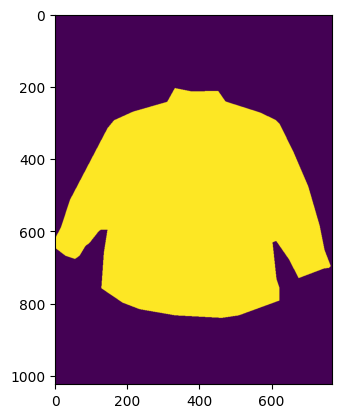

In [ ]:
mask = Image.open("C:/Users/coldbrew/VTON-project/data/roboflow/00037_jpg.rf.661b1df4744c3a1e404520db0f64469c_mask.png").convert('L')
print(mask.size)
mask_np = np.array(mask)
binary_mask = np.where(mask_np > 0, 255, 0).astype(np.uint8)
Image.fromarray(binary_mask).save("mask.jpg")